In [0]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.model_selection import train_test_split
from PIL import Image
import requests
import os

In [3]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

from tensorflow.keras import models, layers, optimizers, utils, datasets, preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import resnet, vgg16, inception_v3

tf.random.set_seed(17)

TensorFlow 2.x selected.


In [4]:
!git clone https://github.com/datawookie/cousteau.git
  
from cousteau.keras.plot import plot_history

Cloning into 'cousteau'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 18 (delta 6), reused 16 (delta 4), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [5]:
!rm -rf car-dataset # allows us to re-clone the dataset w/ updates and get the changes - if folder exists, clone does not work and we won't get anychanges
!git clone https://github.com/GerardWalsh/car-dataset.git

Cloning into 'car-dataset'...
remote: Enumerating objects: 439, done.
remote: Counting objects: 100% (439/439), done.
remote: Compressing objects: 100% (392/392), done.
remote: Total 439 (delta 74), reused 409 (delta 46), pack-reused 0
Receiving objects: 100% (439/439), 21.95 MiB | 19.80 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [0]:
image_paths = list(paths.list_images("car-dataset/train"))

images = []
labels = []

for path in image_paths:
  img = preprocessing.image.load_img(path, target_size=(224, 224))
  img = np.expand_dims(img, axis=0)
  
  images.append(img)

  label = path.split(os.path.sep)[-2]
  if label == "7_5":
    label = 0
  elif label == "7":
    label = 1
  elif label == '6':
    label = 2
  else: 
    label = 3
  labels.append(label)

In [7]:
from collections import Counter
Counter(labels).keys()

dict_keys([0, 3, 2, 1])

In [8]:
Counter(labels).values()

dict_values([44, 36, 85, 60])

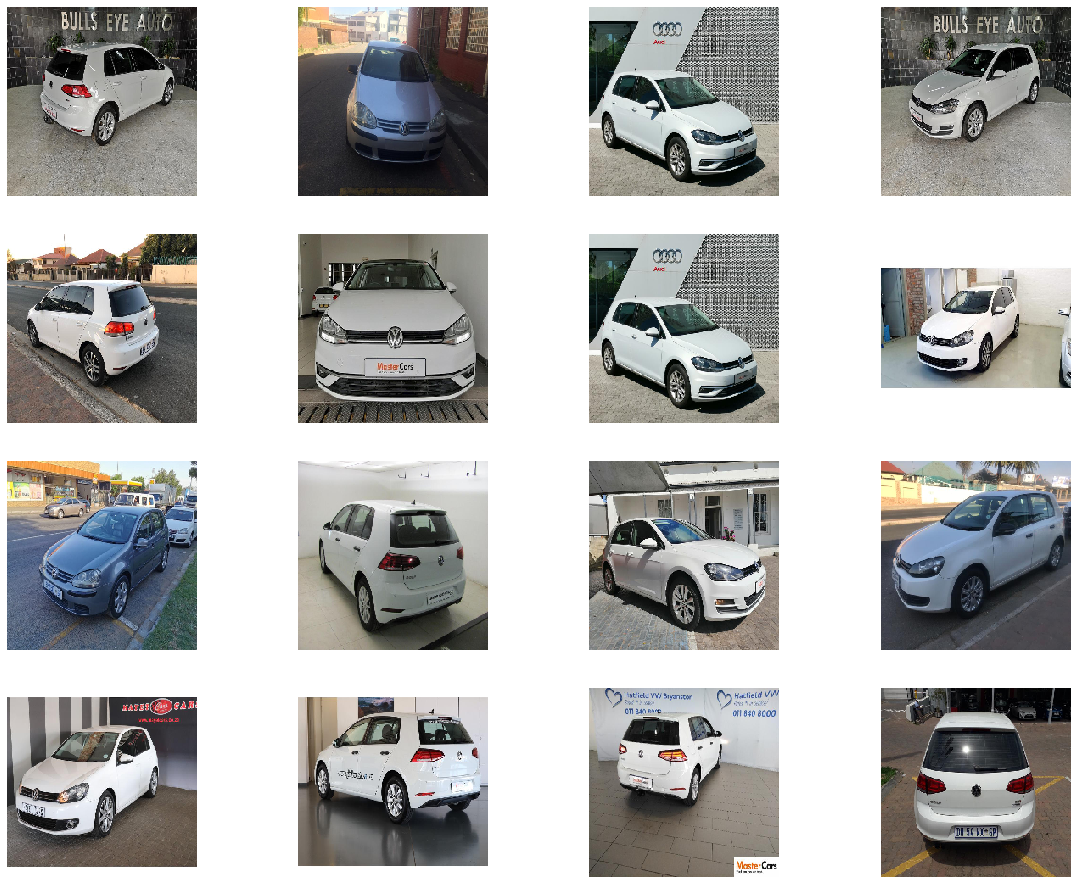

In [9]:
fig = plt.figure(figsize = (20, 16))

for i, img in zip(range(16), random.sample(images, 16)):
  fig.add_subplot(4, 4, i+1)
  plt.axis('off')
  plt.imshow(np.squeeze(img))

plt.show()

In [0]:
datagen = preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [0]:
def augment_image(image, replicates=4):
    images = [image]
    i = 1
    for batch in datagen.flow(image, batch_size=1):
        images.append(batch)
        i += 1
        if i >= replicates:
            break
    return images

In [0]:
REPLICATES = 4

In [0]:
images = [augment_image(image, REPLICATES) for image in images]

In [0]:
images = [image for sublist in images for image in sublist]

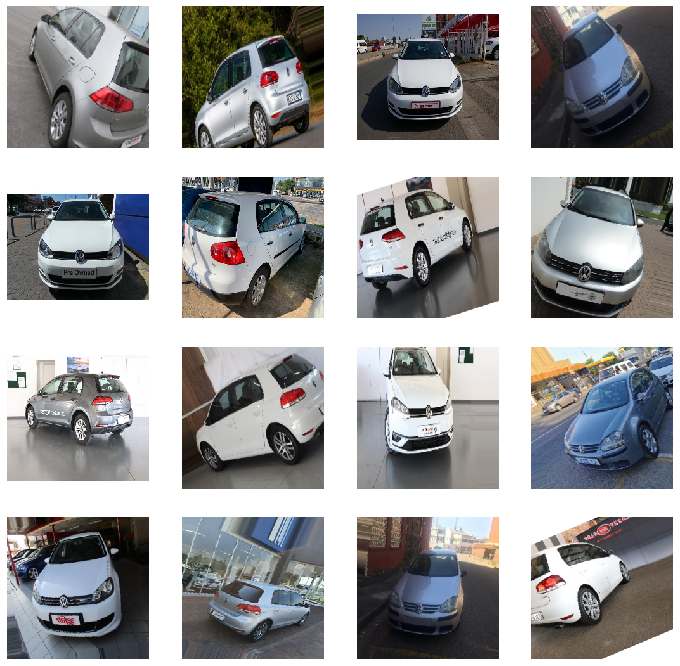

In [15]:
fig = plt.figure(figsize = (12, 12))

for i, img in zip(range(16), random.sample(images, 16)):
  fig.add_subplot(4, 4, i+1)
  plt.axis('off')
  # Transformations result in float32, so cast to uint8.
  plt.imshow(np.squeeze(img).astype('uint8'))

plt.show()

In [0]:
labez = [[label] * REPLICATES for label in labels]

In [0]:
labelz = np.array([label for sublist in labez for label in sublist])

In [18]:
print('Image count (after transform): {}'.format(len(images)), '\n', 'Label count (after transform): {}'.format(len(labelz)))

Image count (after transform): 900 
 Label count (after transform): 900


In [0]:
images = np.concatenate(images)

In [0]:
input_shape = images.shape[1:]

In [0]:
images = resnet.preprocess_input(images)

In [0]:
(X_train, X_test, y_train, y_test) = train_test_split(images, labelz, test_size=0.2, random_state=13)

In [23]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

Using TensorFlow backend.


# Shallow CNN

In [0]:
model = models.Sequential()

model.add(layers.Conv2D(32, kernel_size=3, activation = 'relu', input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=2))

model.add(layers.Conv2D(64, kernel_size=3, activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size=2))      

model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(4, activation = 'softmax'))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 186624)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               23888000  
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               5

In [0]:
batch_size = 32
epochs = 20

In [0]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split=0.2
)

Train on 576 samples, validate on 144 samples
Epoch 1/20
576/576 [==============================] - 9s 16ms/sample - loss: 1.6703 - accuracy: 0.3715 - val_loss: 6.4308 - val_accuracy: 0.2708
Epoch 2/20
576/576 [==============================] - 1s 2ms/sample - loss: 1.0255 - accuracy: 0.5903 - val_loss: 3.5534 - val_accuracy: 0.3194
Epoch 3/20
576/576 [==============================] - 1s 2ms/sample - loss: 0.7555 - accuracy: 0.7083 - val_loss: 2.0250 - val_accuracy: 0.3889
Epoch 4/20
576/576 [==============================] - 1s 2ms/sample - loss: 0.5962 - accuracy: 0.7726 - val_loss: 1.8617 - val_accuracy: 0.4514
Epoch 5/20
576/576 [==============================] - 1s 2ms/sample - loss: 0.3695 - accuracy: 0.8872 - val_loss: 2.7966 - val_accuracy: 0.4167
Epoch 6/20
576/576 [==============================] - 1s 2ms/sample - loss: 0.2225 - accuracy: 0.9479 - val_loss: 1.6653 - val_accuracy: 0.4792
Epoch 7/20
576/576 [==============================] - 1s 2ms/sample - loss: 0.1643 - accu

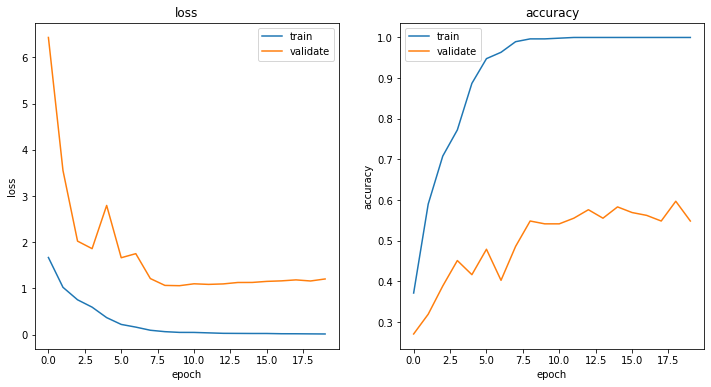

In [29]:
plot_history(history)

In [30]:
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=30,
    verbose=1,
    validation_split=0.2
)

Train on 576 samples, validate on 144 samples
Epoch 1/30
576/576 [==============================] - 1s 2ms/sample - loss: 0.0165 - accuracy: 1.0000 - val_loss: 1.2396 - val_accuracy: 0.5625
Epoch 2/30
576/576 [==============================] - 1s 2ms/sample - loss: 0.0130 - accuracy: 1.0000 - val_loss: 1.2577 - val_accuracy: 0.5486
Epoch 3/30
576/576 [==============================] - 1s 2ms/sample - loss: 0.0144 - accuracy: 1.0000 - val_loss: 1.2907 - val_accuracy: 0.5694
Epoch 4/30
576/576 [==============================] - 1s 2ms/sample - loss: 0.0125 - accuracy: 1.0000 - val_loss: 1.2548 - val_accuracy: 0.5694
Epoch 5/30
576/576 [==============================] - 1s 2ms/sample - loss: 0.0155 - accuracy: 1.0000 - val_loss: 1.2661 - val_accuracy: 0.5625
Epoch 6/30
576/576 [==============================] - 1s 2ms/sample - loss: 0.0122 - accuracy: 1.0000 - val_loss: 1.3006 - val_accuracy: 0.5833
Epoch 7/30
576/576 [==============================] - 1s 2ms/sample - loss: 0.0128 - accur

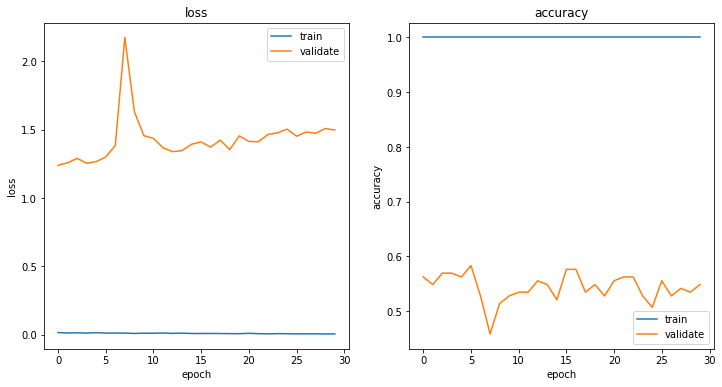

In [31]:
plot_history(history)

In [32]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 55.56% 
Test loss     = 1.561372


## Summary 
Our simple model has stopped learning from the data, as the accuracy is not increasing and our training accuracy is nearly 100%, and will only overfit the data with more training. A more complex model is required - a 3-class accuracy of ~55% is not desireable. 

# Complex model 

In [33]:
base_model = resnet.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

94773248/94765736 [==============================] - 3s 0us/step


In [0]:
base_model.summary()

In [0]:
base_model.trainable = True

In [0]:
resnet50 = models.Sequential()

resnet50.add(base_model)
resnet50.add(layers.Flatten())
resnet50.add(layers.Dense(16, activation='relu'))
resnet50.add(layers.BatchNormalization())
resnet50.add(layers.Dropout(0.5))
resnet50.add(layers.Dense(4, activation='softmax'))

In [0]:
resnet50.summary()

In [0]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(lr=1e-5),
    metrics=['accuracy']
)

In [39]:
history = resnet50.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=120,
    verbose=1,
    validation_split=0.2
)

Train on 576 samples, validate on 144 samples
Epoch 1/120
576/576 [==============================] - 15s 26ms/sample - loss: 1.9832 - accuracy: 0.3264 - val_loss: 2.6858 - val_accuracy: 0.2431
Epoch 2/120
576/576 [==============================] - 7s 12ms/sample - loss: 1.2605 - accuracy: 0.5174 - val_loss: 1.9454 - val_accuracy: 0.3403
Epoch 3/120
576/576 [==============================] - 7s 12ms/sample - loss: 0.9108 - accuracy: 0.6319 - val_loss: 1.5553 - val_accuracy: 0.4028
Epoch 4/120
576/576 [==============================] - 7s 12ms/sample - loss: 0.6999 - accuracy: 0.7378 - val_loss: 1.2694 - val_accuracy: 0.4861
Epoch 5/120
576/576 [==============================] - 7s 12ms/sample - loss: 0.6597 - accuracy: 0.7274 - val_loss: 1.1092 - val_accuracy: 0.5208
Epoch 6/120
576/576 [==============================] - 7s 12ms/sample - loss: 0.5193 - accuracy: 0.8142 - val_loss: 0.9909 - val_accuracy: 0.5694
Epoch 7/120
576/576 [==============================] - 7s 11ms/sample - loss:

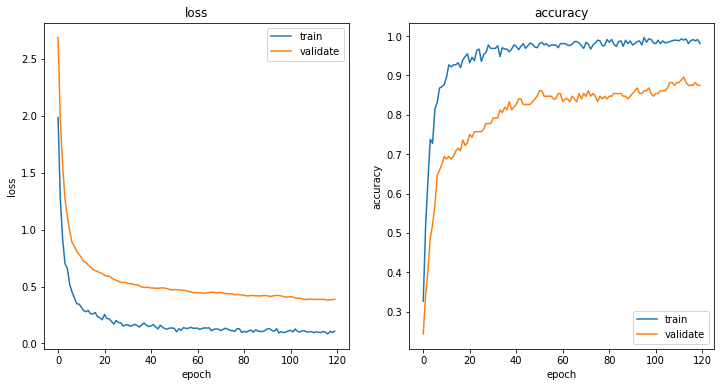

In [40]:
plot_history(history)

In [41]:
history = resnet50.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_split=0.2
)

Train on 576 samples, validate on 144 samples
Epoch 1/20
576/576 [==============================] - 7s 11ms/sample - loss: 0.1140 - accuracy: 0.9896 - val_loss: 0.3923 - val_accuracy: 0.8750
Epoch 2/20
576/576 [==============================] - 7s 11ms/sample - loss: 0.1009 - accuracy: 0.9861 - val_loss: 0.3921 - val_accuracy: 0.8750
Epoch 3/20
576/576 [==============================] - 7s 11ms/sample - loss: 0.1010 - accuracy: 0.9913 - val_loss: 0.3946 - val_accuracy: 0.8750
Epoch 4/20
576/576 [==============================] - 7s 11ms/sample - loss: 0.1036 - accuracy: 0.9878 - val_loss: 0.3944 - val_accuracy: 0.8750
Epoch 5/20
576/576 [==============================] - 7s 11ms/sample - loss: 0.1174 - accuracy: 0.9809 - val_loss: 0.3932 - val_accuracy: 0.8750
Epoch 6/20
576/576 [==============================] - 7s 11ms/sample - loss: 0.0866 - accuracy: 0.9983 - val_loss: 0.3911 - val_accuracy: 0.8889
Epoch 7/20
576/576 [==============================] - 7s 12ms/sample - loss: 0.1046 

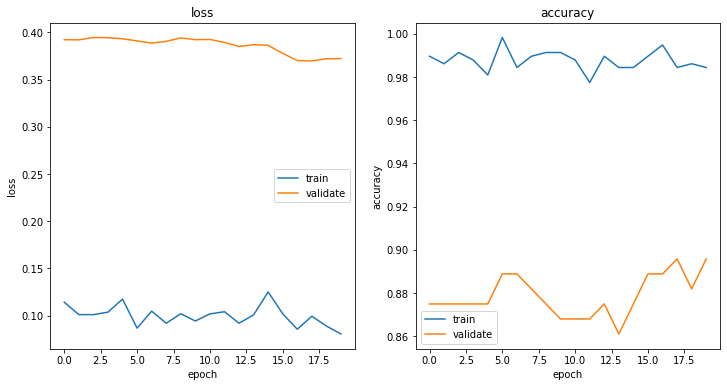

In [42]:
plot_history(history)

In [43]:
score = resnet50.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 91.11% 
Test loss     = 0.377077


## Summary
Resnet50 fits the data relatively well, at 86% accuracy for a 3-class classifaction problem on our test set - could we utilize transfer learning to get a higher accuracy and achieve say 90% accuracy, with our limited data?

# Transfer learning 


In [0]:
base_model = resnet.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

In [0]:
def build_resnet():
  resnet_model = models.Sequential()

  resnet_model.add(base_model)
  resnet_model.add(layers.Flatten())
  resnet_model.add(layers.Dense(16, activation='relu'))
  resnet_model.add(layers.BatchNormalization())
  resnet_model.add(layers.Dropout(0.5))
  resnet_model.add(layers.Dense(4, activation='softmax'))

  return resnet_model 

resnet50_tl = build_resnet()

In [46]:
def trainable_weights(model):
  return sum([int(tf.size(weights)) for weights in model.trainable_weights])

# How many trainable weights in the base model?
trainable_weights(base_model)

23534592

In [0]:
base_model.trainable = False

In [48]:
trainable_weights(base_model)

0

### Important
This is the crucial step - here we are forcing the convolutional kernels (base model) to keep their weights obtained from training on ImageNet and train only our Fully Connected layers (the classifier). 

In [49]:
resnet50_tl.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1605648   
_________________________________________________________________
batch_normalization_2 (Batch (None, 16)                64        
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 68        
Total params: 25,193,492
Trainable params: 1,605,748
Non-trainable params: 23,587,744
__________________________________

In [0]:
resnet50_tl.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(lr=1e-3),
    metrics=['accuracy']
)

Since we are only determining weights for our classifier, not the convolutional kernels, we can train for much less epochs. 

In [51]:
history = resnet50_tl.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=30,
    verbose=1,
    validation_split=0.2
)

Train on 576 samples, validate on 144 samples
Epoch 1/30
576/576 [==============================] - 5s 9ms/sample - loss: 1.2937 - accuracy: 0.4913 - val_loss: 3.5125 - val_accuracy: 0.4375
Epoch 2/30
576/576 [==============================] - 3s 5ms/sample - loss: 0.7174 - accuracy: 0.7170 - val_loss: 2.2334 - val_accuracy: 0.4097
Epoch 3/30
576/576 [==============================] - 3s 5ms/sample - loss: 0.5429 - accuracy: 0.8194 - val_loss: 1.5221 - val_accuracy: 0.4931
Epoch 4/30
576/576 [==============================] - 3s 5ms/sample - loss: 0.4166 - accuracy: 0.9097 - val_loss: 1.1988 - val_accuracy: 0.5208
Epoch 5/30
576/576 [==============================] - 3s 5ms/sample - loss: 0.4031 - accuracy: 0.8889 - val_loss: 0.9944 - val_accuracy: 0.5903
Epoch 6/30
576/576 [==============================] - 3s 5ms/sample - loss: 0.3041 - accuracy: 0.9427 - val_loss: 0.8330 - val_accuracy: 0.6944
Epoch 7/30
576/576 [==============================] - 3s 5ms/sample - loss: 0.2816 - accur

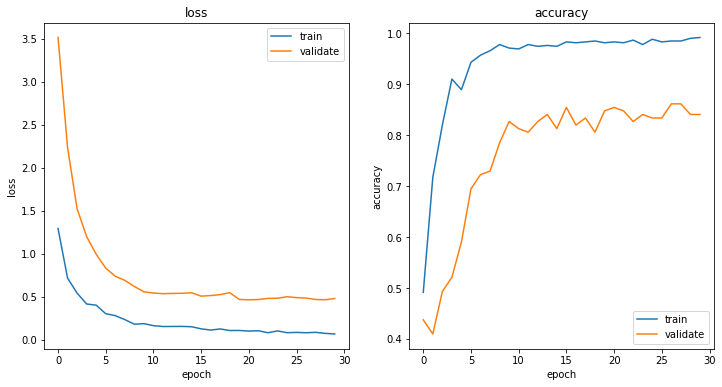

In [52]:
plot_history(history)

In [53]:
score = resnet50_tl.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 76.11% 
Test loss     = 0.620206


# Overfitting
We are overfitting our model to our data - our validation accuracy is much lower than our training accuracy. Let's try use soft label assignments for our training labels to attempt to decrease overfitting. 

In [0]:
resnet50_tl = build_resnet()
base_model.trainable = False

In [55]:
# Check that we are using the pre-trained convolutional kernels
trainable_weights(base_model)

0

In [0]:
from tensorflow.keras.losses import CategoricalCrossentropy
loss = CategoricalCrossentropy(label_smoothing=0.1)

### Important
This is the crucial step in decreasing over-fitting. Keras/Tensorflow has a soft labelling class that we can utilize directly. 

In [0]:
resnet50_tl.compile(
    loss=loss,
    optimizer=optimizers.Adam(lr=1e-02),
    metrics=['accuracy']
)

In [58]:
history = resnet50_tl.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=10,
    verbose=1,
    validation_split=0.2
)

Train on 576 samples, validate on 144 samples
Epoch 1/10
576/576 [==============================] - 5s 9ms/sample - loss: 1.6742 - accuracy: 0.3854 - val_loss: 3.4817 - val_accuracy: 0.3889
Epoch 2/10
576/576 [==============================] - 3s 5ms/sample - loss: 1.0134 - accuracy: 0.6406 - val_loss: 1.2531 - val_accuracy: 0.5486
Epoch 3/10
576/576 [==============================] - 3s 5ms/sample - loss: 0.8856 - accuracy: 0.7101 - val_loss: 0.9455 - val_accuracy: 0.6806
Epoch 4/10
576/576 [==============================] - 3s 5ms/sample - loss: 0.7700 - accuracy: 0.7899 - val_loss: 0.8467 - val_accuracy: 0.7153
Epoch 5/10
576/576 [==============================] - 3s 5ms/sample - loss: 0.6932 - accuracy: 0.8420 - val_loss: 0.8346 - val_accuracy: 0.7292
Epoch 6/10
576/576 [==============================] - 3s 5ms/sample - loss: 0.6354 - accuracy: 0.8663 - val_loss: 0.8609 - val_accuracy: 0.7222
Epoch 7/10
576/576 [==============================] - 3s 5ms/sample - loss: 0.6100 - accur

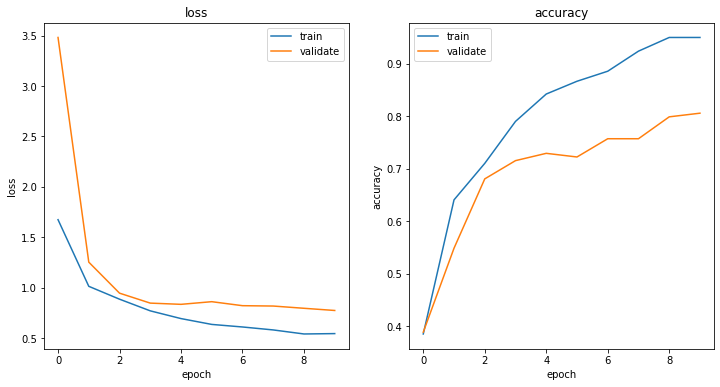

In [59]:
plot_history(history)

In [60]:
score = resnet50_tl.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 68.33% 
Test loss     = 0.891803


## Hyperparameter tuning
Our training heuristics are unstable - let's try a lower learning rate. Transfer learning is promising though, since we achieved 77% accuracy on our test set after only 30 epochs - a feat which took our previous training attempt 120 epochs. 

In [0]:
resnet50_tl = build_resnet()

In [62]:
trainable_weights(base_model)

0

In [0]:
resnet50_tl.compile(
    loss=loss,
    optimizer=optimizers.Adam(lr=1e-2),
    metrics=['accuracy']
)

In [64]:
history = resnet50_tl.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=10,
    verbose=1,
    validation_split=0.2
)

Train on 576 samples, validate on 144 samples
Epoch 1/10
576/576 [==============================] - 6s 10ms/sample - loss: 1.5081 - accuracy: 0.3698 - val_loss: 2.3583 - val_accuracy: 0.4375
Epoch 2/10
576/576 [==============================] - 3s 5ms/sample - loss: 1.0945 - accuracy: 0.5833 - val_loss: 1.4935 - val_accuracy: 0.4583
Epoch 3/10
576/576 [==============================] - 3s 5ms/sample - loss: 0.9886 - accuracy: 0.6632 - val_loss: 1.3505 - val_accuracy: 0.5069
Epoch 4/10
576/576 [==============================] - 3s 5ms/sample - loss: 0.8980 - accuracy: 0.7031 - val_loss: 1.1613 - val_accuracy: 0.5903
Epoch 5/10
576/576 [==============================] - 3s 5ms/sample - loss: 0.7759 - accuracy: 0.8090 - val_loss: 1.0705 - val_accuracy: 0.6319
Epoch 6/10
576/576 [==============================] - 3s 5ms/sample - loss: 0.7450 - accuracy: 0.8108 - val_loss: 0.9650 - val_accuracy: 0.6806
Epoch 7/10
576/576 [==============================] - 3s 5ms/sample - loss: 0.6876 - accu

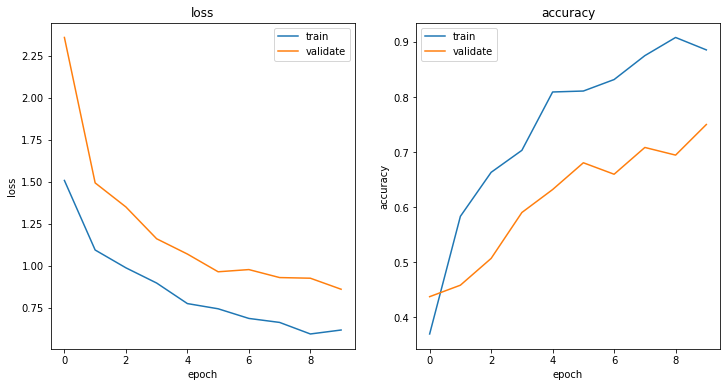

In [65]:
plot_history(history)

In [66]:
score = resnet50_tl.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 65.56% 
Test loss     = 0.954198


# Is there more?

In [67]:
history = resnet50_tl.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=30,
    verbose=1,
    validation_split=0.2
)

Train on 576 samples, validate on 144 samples
Epoch 1/30
576/576 [==============================] - 3s 5ms/sample - loss: 0.5920 - accuracy: 0.8993 - val_loss: 0.8712 - val_accuracy: 0.7222
Epoch 2/30
576/576 [==============================] - 3s 5ms/sample - loss: 0.5732 - accuracy: 0.9323 - val_loss: 0.8540 - val_accuracy: 0.7361
Epoch 3/30
576/576 [==============================] - 3s 5ms/sample - loss: 0.5895 - accuracy: 0.9167 - val_loss: 0.8644 - val_accuracy: 0.7569
Epoch 4/30
576/576 [==============================] - 3s 5ms/sample - loss: 0.5948 - accuracy: 0.9167 - val_loss: 0.9415 - val_accuracy: 0.6597
Epoch 5/30
576/576 [==============================] - 3s 5ms/sample - loss: 0.5768 - accuracy: 0.9132 - val_loss: 0.8967 - val_accuracy: 0.7014
Epoch 6/30
576/576 [==============================] - 3s 5ms/sample - loss: 0.5716 - accuracy: 0.9375 - val_loss: 0.8347 - val_accuracy: 0.7500
Epoch 7/30
576/576 [==============================] - 3s 5ms/sample - loss: 0.5570 - accur

In [68]:
score = resnet50_tl.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 68.33% 
Test loss     = 0.832471


## Summary
Utilizing the resnet50 backbone (feature extractor), we managaed to score 76% accuracy on our test set which is similar to our model that trained resnet50 from scratch, convolutional kernels and all. Can we push that classification accuracy higher by updating some of the kernel weights?

# Fine tune ResNet50

In [0]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

In [0]:
base_model.summary()

In [71]:
# How many trainable weights in the base model?
trainable_weights(base_model)

0

In [72]:
# Make the whole base model trainable (using model property).
base_model.trainable = True
# How many trainable weights in the base model?
trainable_weights(base_model)
# Check that this agrees with the model summary.

23534592

In [0]:
# Set all layers not trainable (using layer properties).
for layer in base_model.layers:
   layer.trainable = False
# Set top two convolutional layers trainable.
for layer in base_model.layers[171:174]:
   layer.trainable = True
    
# How many trainable weights in the base model?
# trainable_weights(base_model)
# Check that this agrees with the model summary.

In [0]:
resnet50_tl.compile(
    loss=loss,
    optimizer=optimizers.Adam(lr=1e-4),
    metrics=['accuracy']
)

In [75]:
resnet50_tl.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_4 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                1605648   
_________________________________________________________________
batch_normalization_4 (Batch (None, 16)                64        
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 68        
Total params: 25,193,492
Trainable params: 2,660,468
Non-trainable params: 22,533,024
__________________________________

In [76]:
history = resnet50_tl.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=50,
    verbose=1,
    validation_split=0.2
)

Train on 576 samples, validate on 144 samples
Epoch 1/50
576/576 [==============================] - 6s 10ms/sample - loss: 0.4875 - accuracy: 0.9705 - val_loss: 0.7471 - val_accuracy: 0.7986
Epoch 2/50
576/576 [==============================] - 3s 5ms/sample - loss: 0.4791 - accuracy: 0.9757 - val_loss: 0.7450 - val_accuracy: 0.7986
Epoch 3/50
576/576 [==============================] - 3s 5ms/sample - loss: 0.4909 - accuracy: 0.9688 - val_loss: 0.7431 - val_accuracy: 0.7917
Epoch 4/50
576/576 [==============================] - 3s 5ms/sample - loss: 0.4790 - accuracy: 0.9740 - val_loss: 0.7376 - val_accuracy: 0.8264
Epoch 5/50
576/576 [==============================] - 3s 5ms/sample - loss: 0.4935 - accuracy: 0.9635 - val_loss: 0.7406 - val_accuracy: 0.7986
Epoch 6/50
576/576 [==============================] - 3s 5ms/sample - loss: 0.4768 - accuracy: 0.9792 - val_loss: 0.7499 - val_accuracy: 0.7986
Epoch 7/50
576/576 [==============================] - 3s 5ms/sample - loss: 0.4989 - accu

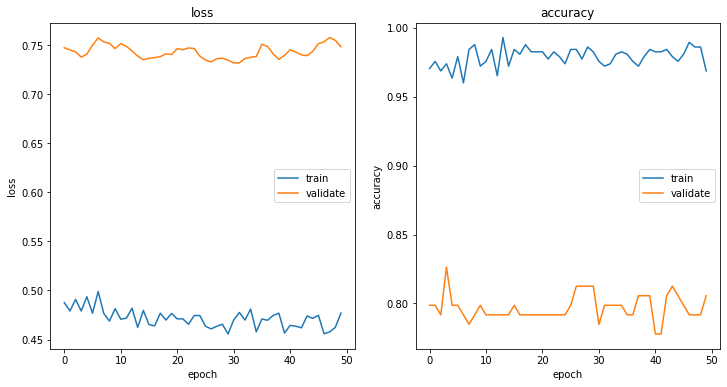

In [77]:
plot_history(history)

In [78]:
history = resnet50_tl.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=10,
    verbose=1,
    validation_split=0.2
)

Train on 576 samples, validate on 144 samples
Epoch 1/10
576/576 [==============================] - 3s 5ms/sample - loss: 0.4627 - accuracy: 0.9774 - val_loss: 0.7479 - val_accuracy: 0.7986
Epoch 2/10
576/576 [==============================] - 3s 5ms/sample - loss: 0.4614 - accuracy: 0.9878 - val_loss: 0.7425 - val_accuracy: 0.7986
Epoch 3/10
576/576 [==============================] - 3s 5ms/sample - loss: 0.4672 - accuracy: 0.9844 - val_loss: 0.7342 - val_accuracy: 0.7986
Epoch 4/10
576/576 [==============================] - 3s 5ms/sample - loss: 0.4796 - accuracy: 0.9705 - val_loss: 0.7308 - val_accuracy: 0.8125
Epoch 5/10
576/576 [==============================] - 3s 5ms/sample - loss: 0.4677 - accuracy: 0.9774 - val_loss: 0.7263 - val_accuracy: 0.8194
Epoch 6/10
576/576 [==============================] - 3s 5ms/sample - loss: 0.4672 - accuracy: 0.9774 - val_loss: 0.7261 - val_accuracy: 0.8125
Epoch 7/10
576/576 [==============================] - 3s 5ms/sample - loss: 0.4671 - accur

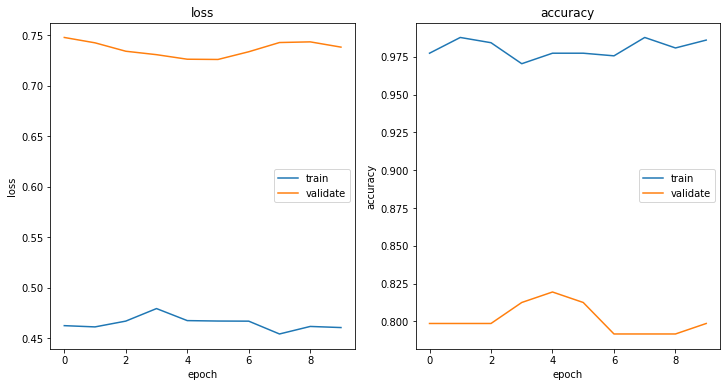

In [79]:
plot_history(history)

In [80]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 55.56% 
Test loss     = 1.561372


# Transfer learning with less complex architechture - VGG16

In [0]:
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

vgg = models.Sequential()

vgg.add(base_model)
vgg.add(layers.Flatten())
vgg.add(layers.Dense(16, activation='relu'))
vgg.add(layers.BatchNormalization())
vgg.add(layers.Dropout(0.5))
vgg.add(layers.Dense(4, activation='softmax'))

base_model.trainable = False

vgg.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(lr=1e-4),
    metrics=['accuracy']
)

history = vgg.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=50,
    verbose=1,
    validation_split=0.2
)

In [81]:
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

58892288/58889256 [==============================] - 2s 0us/step


In [0]:
# base_model.summary()

In [0]:
def build_network(base):

  model = models.Sequential()

  model.add(base)
  model.add(layers.Flatten())
  model.add(layers.Dense(16, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(4, activation='softmax'))

  return model

vgg = build_network(base_model)

In [148]:
vgg.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 16)                401424    
_________________________________________________________________
batch_normalization_7 (Batch (None, 16)                64        
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 68        
Total params: 15,116,244
Trainable params: 7,480,948
Non-trainable params: 7,635,296
___________________________________

In [0]:
base_model.trainable = False

In [0]:
# vgg.summary()

In [0]:
vgg.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(lr=1e-4),
    metrics=['accuracy']
)

In [94]:
history = vgg.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=50,
    verbose=1,
    validation_split=0.2
)

Train on 576 samples, validate on 144 samples
Epoch 1/50
576/576 [==============================] - 9s 15ms/sample - loss: 2.0525 - accuracy: 0.2899 - val_loss: 3.1865 - val_accuracy: 0.3056
Epoch 2/50
576/576 [==============================] - 4s 6ms/sample - loss: 1.3872 - accuracy: 0.4688 - val_loss: 1.6899 - val_accuracy: 0.4306
Epoch 3/50
576/576 [==============================] - 4s 6ms/sample - loss: 1.0508 - accuracy: 0.5938 - val_loss: 1.1712 - val_accuracy: 0.5694
Epoch 4/50
576/576 [==============================] - 4s 6ms/sample - loss: 0.8965 - accuracy: 0.6476 - val_loss: 1.0351 - val_accuracy: 0.6042
Epoch 5/50
576/576 [==============================] - 4s 6ms/sample - loss: 0.7358 - accuracy: 0.7135 - val_loss: 0.9357 - val_accuracy: 0.6806
Epoch 6/50
576/576 [==============================] - 4s 7ms/sample - loss: 0.6206 - accuracy: 0.7743 - val_loss: 0.8990 - val_accuracy: 0.6806
Epoch 7/50
576/576 [==============================] - 4s 7ms/sample - loss: 0.5982 - accu

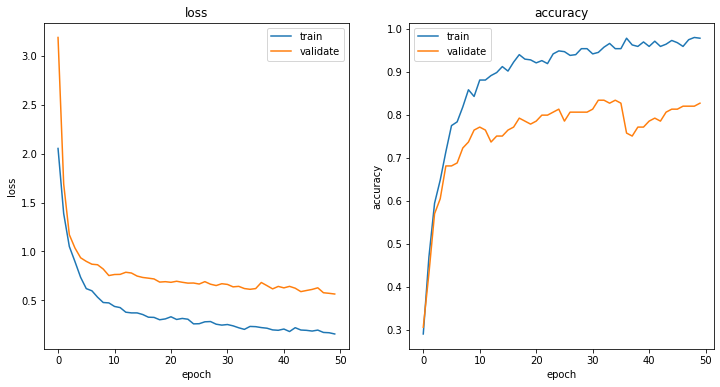

In [95]:
plot_history(history)

In [96]:
score = vgg.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 79.44% 
Test loss     = 0.580120


In [97]:
history = vgg.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=10,
    verbose=1,
    validation_split=0.2
)

Train on 576 samples, validate on 144 samples
Epoch 1/10
576/576 [==============================] - 4s 6ms/sample - loss: 0.1475 - accuracy: 0.9809 - val_loss: 0.5792 - val_accuracy: 0.8264
Epoch 2/10
576/576 [==============================] - 4s 6ms/sample - loss: 0.1754 - accuracy: 0.9705 - val_loss: 0.5809 - val_accuracy: 0.8056
Epoch 3/10
576/576 [==============================] - 4s 6ms/sample - loss: 0.1642 - accuracy: 0.9757 - val_loss: 0.5751 - val_accuracy: 0.8125
Epoch 4/10
576/576 [==============================] - 4s 6ms/sample - loss: 0.1584 - accuracy: 0.9757 - val_loss: 0.5622 - val_accuracy: 0.8194
Epoch 5/10
576/576 [==============================] - 4s 6ms/sample - loss: 0.1584 - accuracy: 0.9774 - val_loss: 0.5865 - val_accuracy: 0.8056
Epoch 6/10
576/576 [==============================] - 4s 6ms/sample - loss: 0.1398 - accuracy: 0.9826 - val_loss: 0.5993 - val_accuracy: 0.8264
Epoch 7/10
576/576 [==============================] - 4s 7ms/sample - loss: 0.1657 - accur

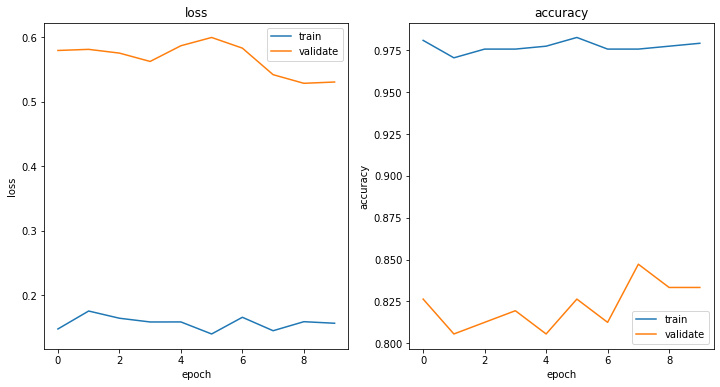

In [98]:
plot_history(history)

In [100]:
score = vgg.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 81.11% 
Test loss     = 0.548141


# Fine tune VGG16

In [102]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_3
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [0]:
base_model.summary()

In [104]:
# Make the whole base model trainable (using model property).
base_model.trainable = True
# How many trainable weights in the base model?
trainable_weights(base_model)
# Check that this agrees with the model summary.

14714688

In [105]:
# Set all layers not trainable (using layer properties).
for layer in base_model.layers:
   layer.trainable = False
# Set top two convolutional layers trainable.
for layer in base_model.layers[15:18]:
   layer.trainable = True
    
# How many trainable weights in the base model?
trainable_weights(base_model)
# Check that this agrees with the model summary.

7079424

In [0]:
vgg.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(lr=0.00001),
    metrics=['accuracy']
)

In [0]:
vgg.summary()

In [107]:
history = vgg.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=10,
    verbose=1,
    validation_split=0.2
)

Train on 576 samples, validate on 144 samples
Epoch 1/10
576/576 [==============================] - 5s 9ms/sample - loss: 0.1258 - accuracy: 0.9826 - val_loss: 0.5464 - val_accuracy: 0.8194
Epoch 2/10
576/576 [==============================] - 4s 7ms/sample - loss: 0.1472 - accuracy: 0.9826 - val_loss: 0.5575 - val_accuracy: 0.8125
Epoch 3/10
576/576 [==============================] - 4s 7ms/sample - loss: 0.1273 - accuracy: 0.9809 - val_loss: 0.5550 - val_accuracy: 0.8264
Epoch 4/10
576/576 [==============================] - 4s 7ms/sample - loss: 0.1549 - accuracy: 0.9618 - val_loss: 0.5318 - val_accuracy: 0.8194
Epoch 5/10
576/576 [==============================] - 4s 7ms/sample - loss: 0.1318 - accuracy: 0.9792 - val_loss: 0.5258 - val_accuracy: 0.8264
Epoch 6/10
576/576 [==============================] - 4s 7ms/sample - loss: 0.1308 - accuracy: 0.9896 - val_loss: 0.5028 - val_accuracy: 0.8194
Epoch 7/10
576/576 [==============================] - 4s 7ms/sample - loss: 0.1328 - accur

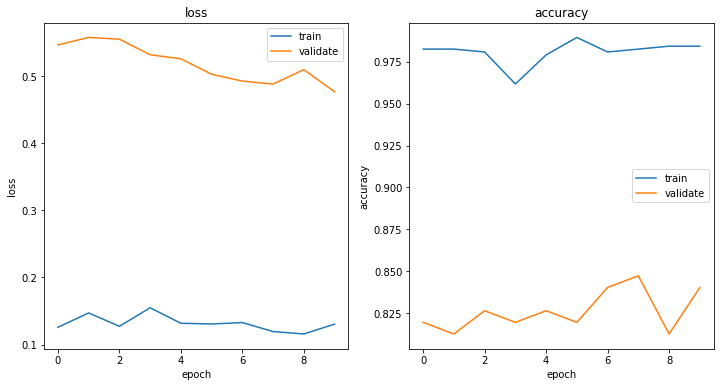

In [108]:
plot_history(history)

In [109]:
history = vgg.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_split=0.2
)

Train on 576 samples, validate on 144 samples
Epoch 1/20
576/576 [==============================] - 4s 7ms/sample - loss: 0.1243 - accuracy: 0.9878 - val_loss: 0.4711 - val_accuracy: 0.8611
Epoch 2/20
576/576 [==============================] - 4s 7ms/sample - loss: 0.1121 - accuracy: 0.9826 - val_loss: 0.4821 - val_accuracy: 0.8264
Epoch 3/20
576/576 [==============================] - 4s 7ms/sample - loss: 0.1132 - accuracy: 0.9861 - val_loss: 0.4879 - val_accuracy: 0.8333
Epoch 4/20
576/576 [==============================] - 4s 7ms/sample - loss: 0.1370 - accuracy: 0.9861 - val_loss: 0.4493 - val_accuracy: 0.8819
Epoch 5/20
576/576 [==============================] - 4s 7ms/sample - loss: 0.1162 - accuracy: 0.9878 - val_loss: 0.4285 - val_accuracy: 0.8819
Epoch 6/20
576/576 [==============================] - 4s 7ms/sample - loss: 0.1151 - accuracy: 0.9878 - val_loss: 0.4436 - val_accuracy: 0.8819
Epoch 7/20
576/576 [==============================] - 4s 7ms/sample - loss: 0.1199 - accur

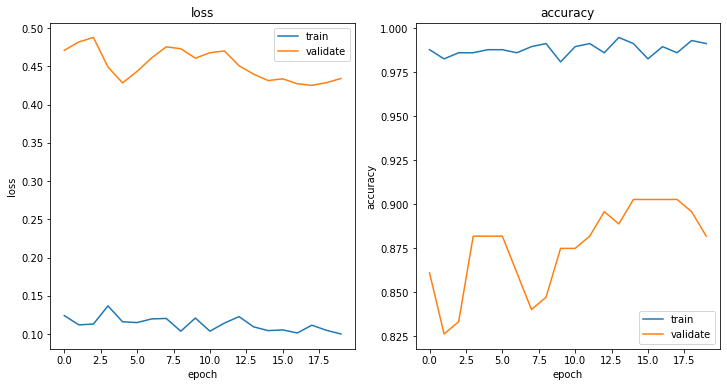

In [110]:
plot_history(history)

In [111]:
score = vgg.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 85.00% 
Test loss     = 0.457225


# VGG from scratch

In [0]:
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = True

In [0]:
vgg_scratch = build_network(base_model)

In [0]:
vgg_scratch.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(lr=1e-4),
    metrics=['accuracy']
)

In [203]:
history = vgg_scratch.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=10,
    verbose=1,
    validation_split=0.2
)

Train on 576 samples, validate on 144 samples
Epoch 1/10
576/576 [==============================] - 10s 17ms/sample - loss: 1.7766 - accuracy: 0.3264 - val_loss: 6.5358 - val_accuracy: 0.4236
Epoch 2/10
576/576 [==============================] - 9s 15ms/sample - loss: 1.3720 - accuracy: 0.3594 - val_loss: 3.3151 - val_accuracy: 0.4306
Epoch 3/10
576/576 [==============================] - 9s 16ms/sample - loss: 1.2331 - accuracy: 0.4271 - val_loss: 1.1651 - val_accuracy: 0.4167
Epoch 4/10
576/576 [==============================] - 9s 16ms/sample - loss: 1.1143 - accuracy: 0.4809 - val_loss: 0.8825 - val_accuracy: 0.5972
Epoch 5/10
576/576 [==============================] - 9s 16ms/sample - loss: 1.0619 - accuracy: 0.5208 - val_loss: 1.1505 - val_accuracy: 0.4028
Epoch 6/10
576/576 [==============================] - 9s 16ms/sample - loss: 1.0243 - accuracy: 0.5642 - val_loss: 3.1657 - val_accuracy: 0.5208
Epoch 7/10
576/576 [==============================] - 9s 16ms/sample - loss: 1.0243

In [204]:
history = vgg_scratch.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=10,
    verbose=1,
    validation_split=0.2
)

Train on 576 samples, validate on 144 samples
Epoch 1/10
576/576 [==============================] - 9s 16ms/sample - loss: 0.9277 - accuracy: 0.6441 - val_loss: 0.8786 - val_accuracy: 0.8264
Epoch 2/10
576/576 [==============================] - 9s 16ms/sample - loss: 0.9045 - accuracy: 0.6771 - val_loss: 1.1235 - val_accuracy: 0.5208
Epoch 3/10
576/576 [==============================] - 10s 17ms/sample - loss: 0.9130 - accuracy: 0.6597 - val_loss: 0.9537 - val_accuracy: 0.6806
Epoch 4/10
576/576 [==============================] - 10s 17ms/sample - loss: 0.8782 - accuracy: 0.6753 - val_loss: 0.8581 - val_accuracy: 0.8889
Epoch 5/10
576/576 [==============================] - 10s 17ms/sample - loss: 0.8663 - accuracy: 0.6892 - val_loss: 1.0920 - val_accuracy: 0.5139
Epoch 6/10
576/576 [==============================] - 9s 16ms/sample - loss: 0.8994 - accuracy: 0.6424 - val_loss: 0.9764 - val_accuracy: 0.6181
Epoch 7/10
576/576 [==============================] - 9s 16ms/sample - loss: 0.91

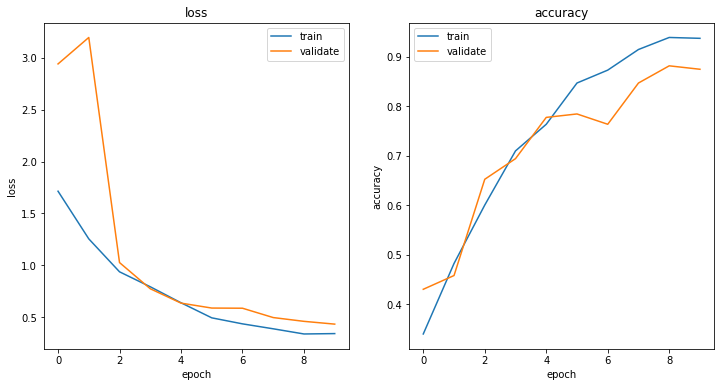

In [185]:
plot_history(history)

In [186]:
score = vgg_scratch.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 86.67% 
Test loss     = 0.452344


# Unseen data

In [0]:
def store_image(img_url, class_type):

  filename = ''
  response = requests.get(img_url)

  if response.status_code == 200:
    directory = 'car-dataset/train/{}'.format(class_type)
    os.chdir(directory)
    filename = str(max(sorted([int(prefix.split('.')[0]) for prefix in os.listdir()])) + 1)

    with open('{}.jpg'.format(filename), 'wb') as f:
      f.write(response.content)

    os.chdir('../../..')

  return directory + '/{}.jpg'.format(filename)

In [0]:
def classify(img_url, class_type, **trained_model):
  
  filename = store_image(img_url, class_type)
  img = image.load_img(filename, target_size=(224, 224))
  plt.imshow(np.squeeze(img).astype('uint8'))

  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)

  for name, model in trained_model.items(): 
    golf = model.predict_classes(img)
    if (golf == 0):
      golf = '7.5'
    elif (golf == 1):
      golf = '7'
    elif (golf == 2):#se:
      golf = '6'
    else: 
      golf = 5
    print('Classifier:', name)
    print('Golf model:', golf, ', proba:', model.predict_proba(img), '\n')

### Golf 5

Classifier: vgg_model
Golf model: 5 , proba: [[2.0276904e-03 8.3793646e-05 2.0291142e-03 9.9585944e-01]] 

Classifier: resnet_model
Golf model: 5 , proba: [[0.02763886 0.00470596 0.0684232  0.899232  ]] 

Classifier: resnet_transfer_model
Golf model: 6 , proba: [[0.16693528 0.27187964 0.34469292 0.21649222]] 



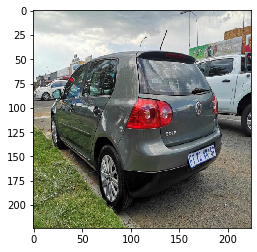

In [156]:
classify(
    'https://www.carmag.co.za/car-images/Gauteng/6091-648349_5/2007-Volkswagen-GOLF-5-GOLF-2.0-COMFORTLINE-5.jpeg',
    '5', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

### Golf 6

Classifier: vgg_model
Golf model: 6 , proba: [[1.2691575e-04 1.4010591e-04 9.9945158e-01 2.8137388e-04]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.01531359 0.04529594 0.885911   0.05347949]] 

Classifier: resnet_transfer_model
Golf model: 6 , proba: [[0.03774207 0.14262067 0.7933018  0.02633549]] 



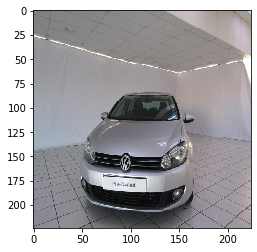

In [158]:
classify(
    'https://img.autotrader.co.za/3760195/Crop800x600',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 6 , proba: [[3.6981684e-05 4.6379850e-05 9.9975199e-01 1.6475719e-04]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.00243951 0.00981224 0.9740228  0.01372542]] 

Classifier: resnet_transfer_model
Golf model: 6 , proba: [[0.04629598 0.13255386 0.802336   0.01881418]] 



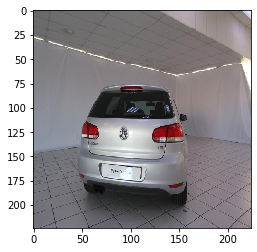

In [159]:
classify(
    'https://img.autotrader.co.za/3760198/Crop800x600',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 6 , proba: [[4.2021270e-03 9.1995003e-05 8.2497466e-01 1.7073119e-01]] 

Classifier: resnet_model
Golf model: 5 , proba: [[0.02357123 0.01338776 0.3917334  0.5713076 ]] 

Classifier: resnet_transfer_model
Golf model: 6 , proba: [[0.04417898 0.09147275 0.82366806 0.04068016]] 



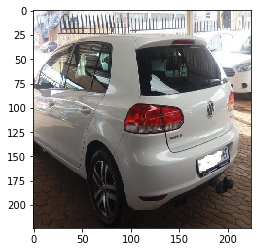

In [160]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5416351_5.jpg?v=1868034972',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.02239014 0.00181631 0.90966237 0.06613117]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.00129556 0.00391842 0.9810889  0.01369723]] 

Classifier: resnet_transfer_model
Golf model: 6 , proba: [[0.03667144 0.12533513 0.76960087 0.06839256]] 



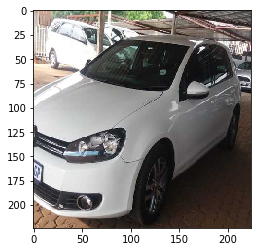

In [161]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5416351.jpg?v=1868034972',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.3616436  0.01038864 0.585071   0.04289671]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.07302615 0.06720459 0.63516676 0.22460246]] 

Classifier: resnet_transfer_model
Golf model: 6 , proba: [[0.11354858 0.0613783  0.7421797  0.0828934 ]] 



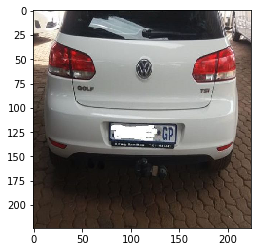

In [162]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5416351_6.jpg?v=1868034972',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.00667702 0.00184912 0.98040456 0.01106926]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.06881484 0.1693159  0.619304   0.14256525]] 

Classifier: resnet_transfer_model
Golf model: 6 , proba: [[0.05097133 0.25700212 0.6032155  0.088811  ]] 



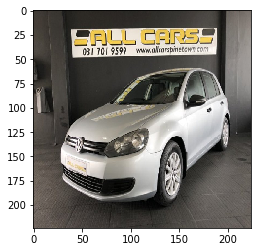

In [163]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_large/5532964.jpg?v=125421204',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 6 , proba: [[1.0452099e-03 7.5641889e-05 9.9287558e-01 6.0035777e-03]] 

Classifier: resnet_model
Golf model: 5 , proba: [[0.01685575 0.03998795 0.31958622 0.6235701 ]] 

Classifier: resnet_transfer_model
Golf model: 6 , proba: [[0.12025043 0.1257051  0.6415717  0.11247279]] 



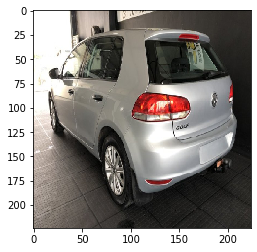

In [164]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_large/5532964_3.jpg?v=125421204',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.22626735 0.0013838  0.47961164 0.2927372 ]] 

Classifier: resnet_model
Golf model: 5 , proba: [[0.32615843 0.03026651 0.08085877 0.5627163 ]] 

Classifier: resnet_transfer_model
Golf model: 6 , proba: [[0.07158119 0.09065916 0.7820073  0.05575243]] 



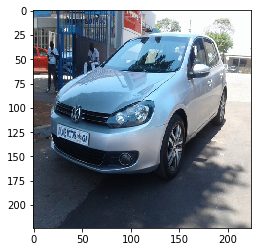

In [165]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518.jpg?v=2265708515',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 6 , proba: [[8.52782000e-03 1.04766805e-04 9.29544151e-01 6.18233383e-02]] 

Classifier: resnet_model
Golf model: 5 , proba: [[0.06303007 0.07221746 0.34704486 0.5177076 ]] 

Classifier: resnet_transfer_model
Golf model: 6 , proba: [[0.01986587 0.05318009 0.8544459  0.0725082 ]] 



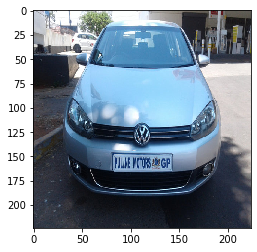

In [166]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518_2.jpg?v=2265708515',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.06424859 0.00613954 0.8097893  0.11982253]] 

Classifier: resnet_model
Golf model: 5 , proba: [[0.09042079 0.01899369 0.17080034 0.71978515]] 

Classifier: resnet_transfer_model
Golf model: 6 , proba: [[0.10331318 0.05479773 0.69074553 0.15114358]] 



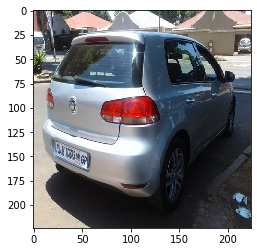

In [167]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518_8.jpg?v=2265708515',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.28844675 0.02720463 0.5777823  0.10656629]] 

Classifier: resnet_model
Golf model: 5 , proba: [[0.3628705  0.02113741 0.07921515 0.5367769 ]] 

Classifier: resnet_transfer_model
Golf model: 6 , proba: [[0.0553441  0.12990575 0.71468437 0.10006578]] 



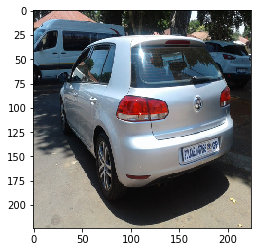

In [168]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518_7.jpg?v=2265708515',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 6 , proba: [[3.7278822e-03 7.8699953e-04 9.8649663e-01 8.9884689e-03]] 

Classifier: resnet_model
Golf model: 5 , proba: [[0.25140855 0.04869124 0.3147834  0.38511685]] 

Classifier: resnet_transfer_model
Golf model: 6 , proba: [[0.06169781 0.11877427 0.7735069  0.04602102]] 



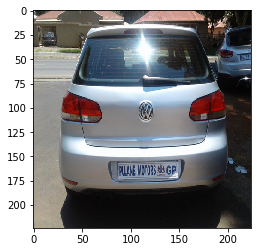

In [169]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518_6.jpg?v=2265708515',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.00723472 0.00616212 0.91044676 0.07615634]] 

Classifier: resnet_model
Golf model: 5 , proba: [[0.04471714 0.0225071  0.21841815 0.71435755]] 

Classifier: resnet_transfer_model
Golf model: 6 , proba: [[0.04212231 0.14781383 0.7238466  0.08621719]] 



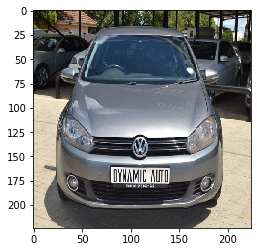

In [170]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5530306_2.jpg?v=4074465811',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

### Golf 7


Classifier: vgg_scratch
Golf model: 7 , proba: [[1.4576907e-03 6.2163639e-01 4.6640023e-04 3.7643945e-01]] 

Classifier: vgg_model
Golf model: 6 , proba: [[0.02376863 0.00347937 0.89216727 0.08058468]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.0966571  0.11124491 0.4366825  0.35541543]] 

Classifier: resnet_transfer_model
Golf model: 6 , proba: [[0.11625803 0.25250408 0.585973   0.04526486]] 



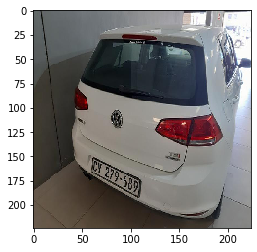

In [205]:
classify(
    'https://img.autotrader.co.za/4873898/Crop800x600',
    '7', vgg_scratch = vgg_scratch, vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_scratch
Golf model: 5 , proba: [[0.18021742 0.23143655 0.26801437 0.32033166]] 

Classifier: vgg_model
Golf model: 7 , proba: [[3.4962825e-03 9.9543238e-01 5.0665013e-04 5.6470529e-04]] 

Classifier: resnet_model
Golf model: 5 , proba: [[0.10119136 0.1528902  0.12484356 0.62107486]] 

Classifier: resnet_transfer_model
Golf model: 6 , proba: [[0.07900355 0.39420518 0.4419896  0.0848017 ]] 



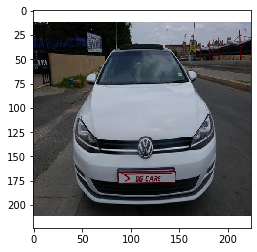

In [206]:
classify(
    'https://img.autotrader.co.za/4974734/Crop800x600',
    '7', vgg_scratch = vgg_scratch, vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_scratch
Golf model: 6 , proba: [[0.17840046 0.2620081  0.30781776 0.2517737 ]] 

Classifier: vgg_model
Golf model: 7 , proba: [[0.1589139  0.7511131  0.04390579 0.04606713]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.05802385 0.09860181 0.45031083 0.39306358]] 

Classifier: resnet_transfer_model
Golf model: 6 , proba: [[0.06698777 0.22867379 0.6578972  0.04644131]] 



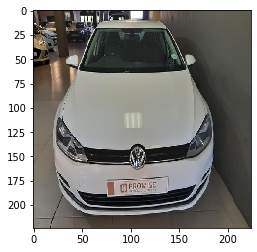

In [207]:
classify(
         'https://img.autotrader.co.za/4873896/Crop800x600',
         '7', vgg_scratch = vgg_scratch, vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
         )

### Golf 7.5

Classifier: vgg_scratch
Golf model: 6 , proba: [[0.14880309 0.31491944 0.3553795  0.18089795]] 

Classifier: vgg_model
Golf model: 7 , proba: [[5.4888357e-03 9.9430746e-01 3.3283213e-05 1.7043645e-04]] 

Classifier: resnet_model
Golf model: 7 , proba: [[0.20094496 0.6412464  0.02700832 0.13080035]] 

Classifier: resnet_transfer_model
Golf model: 7 , proba: [[0.09123141 0.78180695 0.10594465 0.02101697]] 



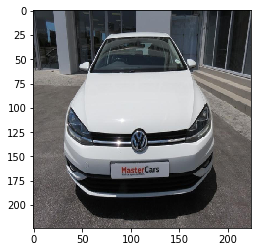

In [208]:
classify(
    'https://img.autotrader.co.za/4971489/Crop800x600',
    '7_5', vgg_scratch = vgg_scratch, vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_scratch
Golf model: 7 , proba: [[0.15191446 0.35647106 0.32573006 0.16588442]] 

Classifier: vgg_model
Golf model: 7 , proba: [[2.2632164e-01 7.6496196e-01 7.5068115e-04 7.9656783e-03]] 

Classifier: resnet_model
Golf model: 5 , proba: [[0.14874206 0.30680364 0.06657071 0.47788358]] 

Classifier: resnet_transfer_model
Golf model: 6 , proba: [[0.21176349 0.31359932 0.38210955 0.09252761]] 



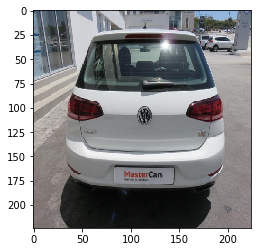

In [209]:
classify(
    'https://img.autotrader.co.za/4971493/Crop800x600',
    '7_5', vgg_scratch = vgg_scratch, vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_scratch
Golf model: 6 , proba: [[0.11289722 0.2968832  0.44026488 0.1499547 ]] 

Classifier: vgg_model
Golf model: 7.5 , proba: [[0.5097002  0.19018282 0.11081011 0.1893069 ]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.03082497 0.06062706 0.46413553 0.44441247]] 

Classifier: resnet_transfer_model
Golf model: 6 , proba: [[0.11416193 0.30624703 0.5329992  0.04659178]] 



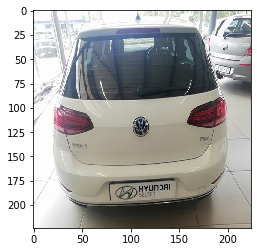

In [210]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5570873_6.jpg?v=317154964',
    '7_5', vgg_scratch = vgg_scratch, vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_scratch
Golf model: 6 , proba: [[0.12641105 0.31032056 0.3969781  0.16629028]] 

Classifier: vgg_model
Golf model: 7 , proba: [[0.06086496 0.92248887 0.00830347 0.00834266]] 

Classifier: resnet_model
Golf model: 7 , proba: [[0.19387187 0.5832381  0.07779902 0.145091  ]] 

Classifier: resnet_transfer_model
Golf model: 6 , proba: [[0.06060307 0.23539369 0.65397316 0.05003007]] 



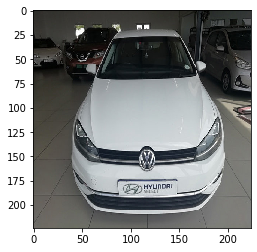

In [211]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5570873_3.jpg?v=317154964',
    '7_5', vgg_scratch = vgg_scratch, vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_scratch
Golf model: 5 , proba: [[0.18122764 0.14422718 0.18170571 0.49283955]] 

Classifier: vgg_model
Golf model: 7 , proba: [[0.08381843 0.90165764 0.00345789 0.01106606]] 

Classifier: resnet_model
Golf model: 5 , proba: [[0.04595293 0.0450206  0.31802607 0.59100044]] 

Classifier: resnet_transfer_model
Golf model: 6 , proba: [[0.13513471 0.19408168 0.63288164 0.03790197]] 



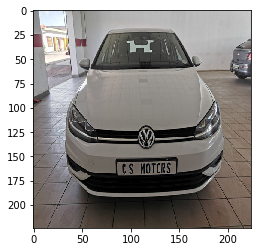

In [212]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5428529_2.jpg?v=158700226',
    '7_5', vgg_scratch = vgg_scratch, vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_scratch
Golf model: 6 , proba: [[0.09819331 0.19662516 0.4378107  0.26737082]] 

Classifier: vgg_model
Golf model: 7 , proba: [[0.42382053 0.45666832 0.01859911 0.10091208]] 

Classifier: resnet_model
Golf model: 5 , proba: [[0.19340819 0.30583528 0.06574674 0.43500975]] 

Classifier: resnet_transfer_model
Golf model: 7 , proba: [[0.1651724  0.44297642 0.3531207  0.03873049]] 



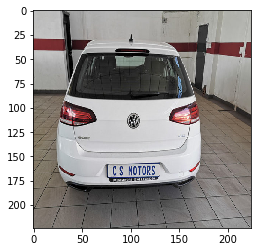

In [213]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5428529_7.jpg?v=158700226',
    '7_5', vgg_scratch = vgg_scratch, vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

In [0]:
# 1. Change classify function to accept multiple models
# 2. Build simple network to count side/front/rear shots of each class
# 3. Investigate network ensemble